In [15]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import h5py
import os
import glob                                                                                                                                                        
import wget
import torch
import sys
dataloader_path = '/arc/home/ashley/SSL/git/dark3d/src/models/training_framework/'
sys.path.insert(0, dataloader_path)
import dataloaders
canfar_data_path = '/arc/projects/unions/ssl/data/processed/unions-cutouts/ugriz_lsb/10k_per_h5/'

In [2]:
from models_mae import mae_vit_large_patch16
mae_model = mae_vit_large_patch16()

2024-02-28 18:47:16,998 - jax._src.path - DEBUG - etils.epath found. Using etils.epath for file I/O.
2024-02-28 18:47:17,778 - git.cmd - DEBUG - Popen(['git', 'version'], cwd=/arc/home/ashley/SSL/git/mae_jan21/AstroMASK, stdin=None, shell=False, universal_newlines=False)
2024-02-28 18:47:17,785 - git.cmd - DEBUG - Popen(['git', 'version'], cwd=/arc/home/ashley/SSL/git/mae_jan21/AstroMASK, stdin=None, shell=False, universal_newlines=False)
2024-02-28 18:47:17,798 - wandb.docker.auth - DEBUG - Trying paths: ['/arc/home/ashley/.docker/config.json', '/arc/home/ashley/.dockercfg']
2024-02-28 18:47:17,799 - wandb.docker.auth - DEBUG - No config file found
2024-02-28 18:47:18,077 - sentry_sdk.errors - DEBUG - [Tracing] Create new propagation context: {'trace_id': '1e15537fbe4e4d39903c38abcf5ba9c0', 'span_id': '9bb744a9894cee16', 'parent_span_id': None, 'dynamic_sampling_context': None}


In [3]:
checkpoint_path = "/arc/projects/unions/ssl/data/processed/unions-cutouts/ugriz_lsb/10k_per_h5/mae/output_dir/to_save/checkpoint-60.pth"
checkpoint = torch.load(checkpoint_path)
mae_model.load_state_dict(checkpoint['model'])

device = torch.device('cuda')
mae_model.to(device)
mae_model.eval()

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(5, 1024, kernel_size=(8, 8), stride=(8, 8))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (d

In [4]:
# read in redshift files
matches = pd.read_csv('spencer_redshifts.csv').sample(frac = 1) # random shuffle is applied to table
matches.head()

,Unnamed: 0,ra_2,dec_2,zspec,file_num,index
67884,81753,145.697874,36.642169,-0.000061,459,9602
173133,187002,147.765665,30.822350,0.100000,441,8292
154952,168821,15.642527,30.544306,0.300000,411,5487
27712,41458,129.924828,32.400721,3.350719,551,4792
27751,41498,130.201426,33.314321,2.097000,221,4320


2024-02-28 18:48:46,476 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-02-28 18:48:46,480 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-02-28 18:48:46,485 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-02-28 18:48:46,487 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/opt/conda/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-02-28 18:48:46,488 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/opt/conda/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', 

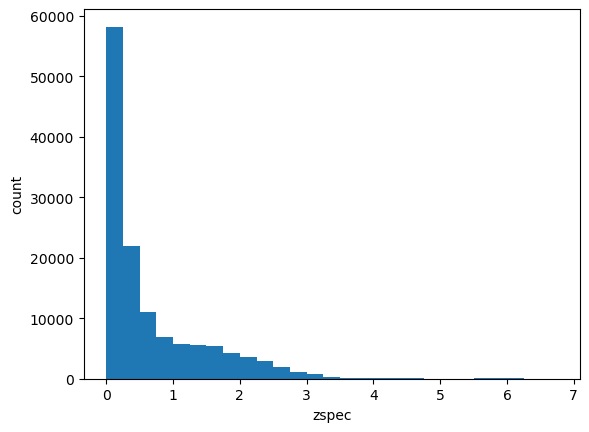

[5.8179e+04 2.1900e+04 1.1044e+04 6.9430e+03 5.6630e+03 5.6510e+03
 5.3680e+03 4.1930e+03 3.5940e+03 2.9470e+03 1.8630e+03 1.1160e+03
 7.1300e+02 3.1400e+02 1.6200e+02 1.0000e+02 9.6000e+01 5.1000e+01
 5.1000e+01 3.5000e+01 2.1000e+01 2.8000e+01 4.8000e+01 4.2000e+01
 4.0000e+01 5.0000e+00 4.0000e+00]


In [5]:
# look at redshift distribution
counts, bins, patches = plt.hist(matches['zspec'], bins=np.arange(0,max(matches['zspec']),0.25))
plt.ylabel('count')
plt.xlabel('zspec')
plt.show()
print(counts)

In [6]:
# filter out the extremely high and extremely low redshift entries
matches = matches[matches['zspec']>0.1]
matches = matches[matches['zspec']<6]

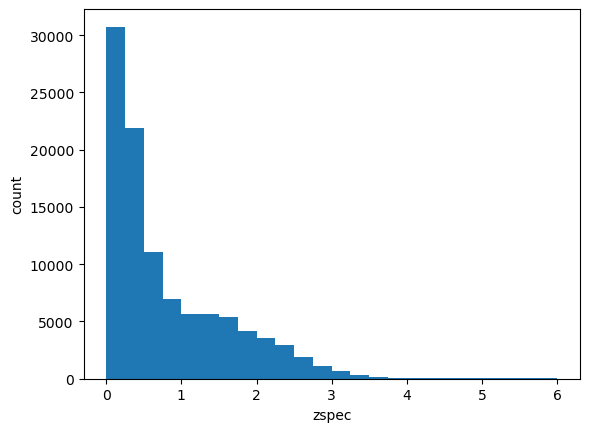

[3.0742e+04 2.1900e+04 1.1044e+04 6.9430e+03 5.6630e+03 5.6510e+03
 5.3680e+03 4.1930e+03 3.5940e+03 2.9470e+03 1.8630e+03 1.1160e+03
 7.1300e+02 3.1400e+02 1.6200e+02 1.0000e+02 9.6000e+01 5.1000e+01
 5.1000e+01 3.5000e+01 2.1000e+01 2.8000e+01 4.8000e+01 4.2000e+01]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.  ]


In [7]:
# look at distribution again with specified bin size
bin_size = 0.25
counts, bins, patches = plt.hist(matches['zspec'], bins=np.arange(0,6+bin_size, bin_size))
plt.ylabel('count')
plt.xlabel('zspec')
plt.show()
print(counts)
print(bins)

In [35]:
### now self-sample for flat distribution ###
# smallest bar seems to have a count of 21 so to insure a flat
# distribution we will just sample each bar up to 20 counts
dict = {}
for b in bins:
    dict[b] = []

match_zspec = np.array(matches['zspec'])
for i in range(len(match_zspec)):
    s = np.round(match_zspec[i] // bin_size) * bin_size # this part not correct? fixed now!

    # making this much larger to see if it helps
    if len(dict[s]) < 200:# 20: # you can make this number larger (like 50) without a significant change in the distribution
        dict[s].append(i)

train_set = list(itertools.chain.from_iterable(dict.values()))

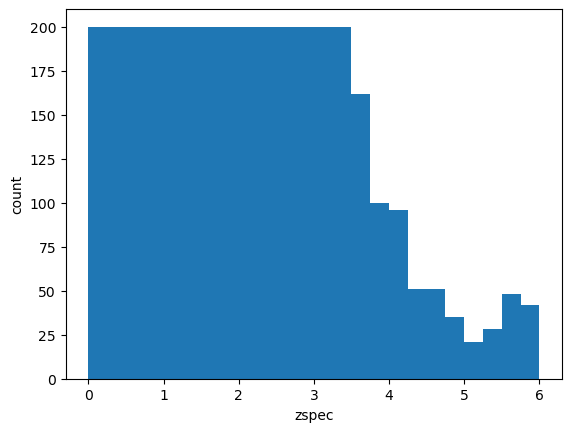

total entries in train_lst: 3434


In [36]:
# visualize the distribution of this train list to make sure it is flat
counts, bins, patches = plt.hist(match_zspec[train_set], bins=np.arange(0,6+bin_size, bin_size)) 
plt.ylabel('count')
plt.xlabel('zspec')
plt.show()
print('total entries in train_lst:', len(train_set))

In [37]:
# loop over table and save representations and redshifts for all entries in this train_set
cutouts = []
redshifts = []
index_count = 0
for i, row in matches.iterrows():
    if index_count in train_set:
        redshifts.append(row['zspec'])
        file_num = int(row['file_num']) 
        filename = f'cutout.stacks.ugriz.lsb.200x200.{file_num}.10000.h5'
        f = h5py.File(canfar_data_path + filename,'r')
        index = int(row['index'])
        image = f['images'][index]
        cutouts.append(dataloaders.utils.crop_center(image, cropx=64, cropy=64))

    index_count +=1 

cutouts = np.array(cutouts)
cutouts = torch.from_numpy(cutouts)
cutouts = cutouts.float().to(device, non_blocking=True)
with torch.no_grad():
    with torch.cuda.amp.autocast():
        latent_representation, _, _ = mae_model.forward_encoder(cutouts, mask_ratio=0.0)
        
del cutouts
latent_representation = latent_representation.cpu().numpy()
batch_size, extra, dim = latent_representation.shape
flattened_representation = latent_representation.reshape(batch_size, extra*dim)
del latent_representation

In [38]:
# normalize flattened representations - have tried with and without this
norms = np.linalg.norm(flattened_representation, keepdims=True, axis=0) 
normalized_reps = flattened_representation / norms
del flattened_representation
print(normalized_reps.shape) 
print(norms.shape)

(3434, 66560)
(1, 66560)


Learned Parameters:
Weights: [-0.06372982 -0.141377   -0.2344979  ...  0.06192767  0.0420836
  0.06300242]
Intercept: 2.849744


Text(0.5, 1.0, 'training set')

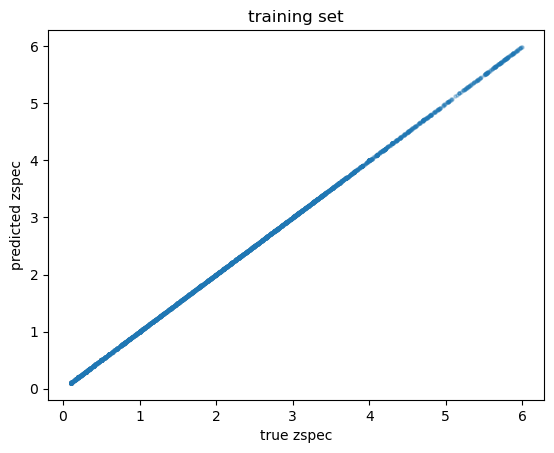

In [39]:
X = normalized_reps
y = np.array(redshifts)

linear_model = LinearRegression()
linear_model.fit(X, y)

print("Learned Parameters:")
print("Weights:", linear_model.coef_)
print("Intercept:", linear_model.intercept_)

y_pred = linear_model.predict(X)
plt.scatter(y, y_pred, alpha=0.3, s=5)
plt.ylabel('predicted zspec')
plt.xlabel('true zspec')
plt.title('training set')
plt.show()

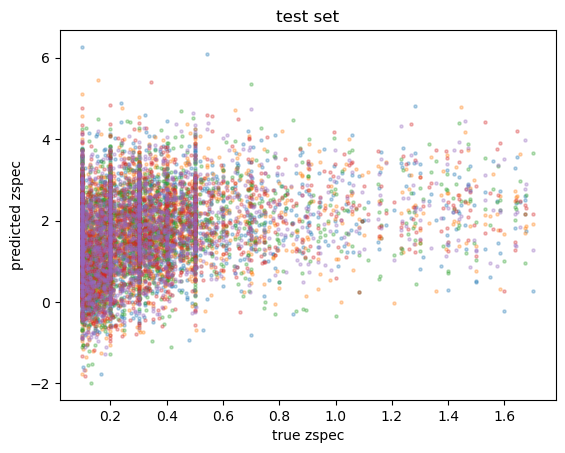

In [43]:
iterations = 5
for k in range(iterations):
    # get a 2k sample to use as test set (could do this sample better)
    cutouts = []
    redshifts = []
    index_count = 0
    for i, row in matches.iterrows():
        if not index_count in train_set:
            redshifts.append(row['zspec'])
            file_num = int(row['file_num']) 
            filename = f'cutout.stacks.ugriz.lsb.200x200.{file_num}.10000.h5'
            f = h5py.File(canfar_data_path + filename,'r')
            index = int(row['index'])
            image = f['images'][index]
            cutouts.append(dataloaders.utils.crop_center(image, cropx=64, cropy=64))
    
        index_count +=1 
        if len(redshifts) >= 2000:
            break
    
    cutouts = np.array(cutouts)
    cutouts = torch.from_numpy(cutouts)
    cutouts = cutouts.float().to(device, non_blocking=True)
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            latent_representation, _, _ = mae_model.forward_encoder(cutouts, mask_ratio=0.0)
    
    del cutouts
    
    latent_representation = latent_representation.cpu().numpy()
    batch_size, extra, dim = latent_representation.shape
    flattened_representation = latent_representation.reshape(batch_size, extra*dim)
    del latent_representation
    
    normalized_reps = flattened_representation / norms
    del flattened_representation

    redshifts = np.array(redshifts)

    y_pred_test = linear_model.predict(normalized_reps)
    plt.scatter(redshifts, y_pred_test, alpha=0.3, s=5)
    plt.ylabel('predicted zspec')
    plt.xlabel('true zspec')
    plt.title('test set')

plt.show()

I think it must be overtraining? I also think that there must be a better form for me to input the representations into the linear regression model?

I've tried varying the amount of samples in each bin and the range to predict over but it still doesn't seem to work :(